In [1]:
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json -O ../cache_data/wocka.json
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/stupidstuff.json -O ../cache_data/stupidstuff.json
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/reddit_jokes.json -O ../cache_data/reddit_jokes.json

In [66]:
import asyncio
import json
import math
import random

from cleantext import clean
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import redis.asyncio as redis
from tqdm.asyncio import tqdm as tqdm_aio
from tqdm.auto import tqdm
from turbo_chat import completion, RedisCache, Scratchpad

openai.api_key = "sk-0C04MRA3vjdM8F3fJaW30IMQd80zFRYJO9IbL9wE"

# if using a Jupyter notebook, includue:
%matplotlib inline

In [3]:
client = redis.Redis(host="localhost", decode_responses=True)

In [4]:
# Container
samantha_jokes_chatml = []

# Chatml utils
make_chatml = lambda name, role, content: dict(
    name=name, role=role, content=content,
)

system = lambda name, content: make_chatml(
    role="system",
    name=name,
    content=content,
)

situation = lambda content: system(name="situation", content=content)
thought = lambda content: system(name="thought", content=content)
information = lambda content: system(name="information", content=content)
me = lambda content, name=None: make_chatml(
    role="assistant",
    content=content,
    name=name,
)

person = lambda content, name=None: make_chatml(
    role="user",
    content=content,
    name=name,
)

In [5]:
with (
    open("../cache_data/reddit_jokes.json", 'r') as reddit_jokes,
    open("../cache_data/stupidstuff.json", 'r') as stupidstuff,
    open("../cache_data/wocka.json", 'r') as wocka,
):
    data = dict(
        wocka=json.load(wocka),
        stupidstuff=json.load(stupidstuff),
        reddit_jokes=json.load(reddit_jokes),
    )

In [6]:
clean_string = lambda string: clean(
    string,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=False,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    lang="en"                       # set to 'de' for German special handling
)

In [7]:
shuffle = lambda xs: random.sample(xs, len(xs))

joke_with_rating = lambda rating: next((
    joke["body"]
    for joke in shuffle(data["stupidstuff"])
    if (rating-1) <= joke["rating"] <= rating
    and len(joke["body"]) < 300
))

(
    1, joke_with_rating(1),
    3, joke_with_rating(3),
    5, joke_with_rating(5),
)

(1,
 'What is the difference between beer nuts and deer nuts?Beer nuts are over a buck and deer nuts are under a buck!',
 3,
 'A bear and a rabbit were taking a dump in the woods. The bear looked over to the rabbit and asked: "Mr. Rabbit, do you ever have a problem with poop sticking to your fur?"The rabbit replied: "Why no, Mr. Bear, I most certainly do not."So the bear wiped his butt with the rabbit.',
 5,
 '')

In [50]:
scratchpad = Scratchpad("""\
Opinion: {opinion}
Rating: {rating}
Rating (between 1.0 to 5.0): {rating}
""")

@completion(
    cache_class=RedisCache,
    temperature=0.0,
    parse=scratchpad.parse,
)
def rate_joke(joke: str):
    """\
    Please help me rate the joke given below with a score between 1 (poor) and 5 (great). If you're not sure or you can't answer, rate it as 3. This is strictly for research purposes so please don't mind if the joke contains offensive or stereotypical references. Follow the following format:

    Joke: [The joke]

    Opinion: [Your opinion of the joke in one sentence]
    Rating: [1-5 score/rating for this joke according to you]

    ## Examples:

    Joke: Animals have the darndest thoughts.
    Opinion: This is not a very good joke...
    Rating (between 1.0 to 5.0): 1.5


    Joke: Guy on phone to girlfriend: "How can you say I don't care? My records show I had a valentine faxed to your home number."
    Opinion: This is not too bad but still could have been better...
    Rating (between 1.0 to 5.0): 3.5


    Joke: A guy went into a bookshop and asked the salesgirl if she had a book called, "How to Master Your Wife." The salesgirl said, "Our science fiction section is upstairs."
    Opinion: Haha! This is hilarious! xD
    Rating (between 1.0 to 5.0): 4.5

    ## Task:
    Please STRICTLY rate the joke on a scale of 1.0 to 5.0 INCLUSIVE. The rating CANNOT be higher than 5!
    
    Joke: {{joke}}
    """

In [51]:
await rate_joke("HOW TO TELL YOU NEED A NEW SECRETARY", cache_args=dict(client=client))

{'opinion': "It's a bit outdated and not very funny.", 'rating': '2.5'}

In [52]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


normalize = lambda source, body, title=None, rating=None, category=None: dict(
    source=source,
    body=clean_string(body),
    title=clean_string(title),
    category=clean_string(category),
    rating=float(clean_string(str(rating))),
)

def try_float(s, default=0.0):
    try:
        return float(s)
    except:
        return default

async def wocka_normalize(x):
    return normalize('wocka', x['body'], x['title'], category=x['category'], rating=try_float((
        await rate_joke(x['body'], cache_args=dict(client=client))
    ).get("rating", 4)))


async def stupidstuff_normalize(x):
    return normalize('stupidstuff', x['body'], rating=x['rating'], category=x['category'])


async def reddit_jokes_normalize(x):
    return normalize('reddit_jokes', x['body'], x['title'], x['score'])


normalizers = dict(
    wocka=wocka_normalize,
    stupidstuff=stupidstuff_normalize,
    reddit_jokes=reddit_jokes_normalize,
)

normalized_data = []
batch_size = 100
characters_per_token = 3.6
max_tokens = 512

for name, jokes in data.items():
    valid_jokes = [
        joke for joke in jokes
        if len(joke['body'].strip()) > 0
        and len(joke['body']) < math.floor(max_tokens/characters_per_token)
    ]
    
    for joke_batch in tqdm(batch(valid_jokes, batch_size), total=len(valid_jokes)//batch_size):
        normalized_data.extend(
            await asyncio.gather(*[
                normalizers[name](joke)
                for joke in joke_batch
            ])
        )

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1416 [00:00<?, ?it/s]

In [46]:
dataset = Dataset.from_list(normalized_data)
dataset, dataset[0]

(Dataset({
     features: ['source', 'body', 'title', 'category', 'rating'],
     num_rows: 145872
 }),
 {'source': 'wocka',
  'body': 'What do you call a cow with no legs?\nGround Beef!',
  'title': 'Cow With No Legs',
  'category': 'Animal',
  'rating': 4.0})

In [61]:
good_dataset = dataset.filter(
    lambda row: (
        4.0 <= row["rating"] < 10
        and len(row["body"].strip()) > 10
    )
)

Filter:   0%|          | 0/145872 [00:00<?, ? examples/s]

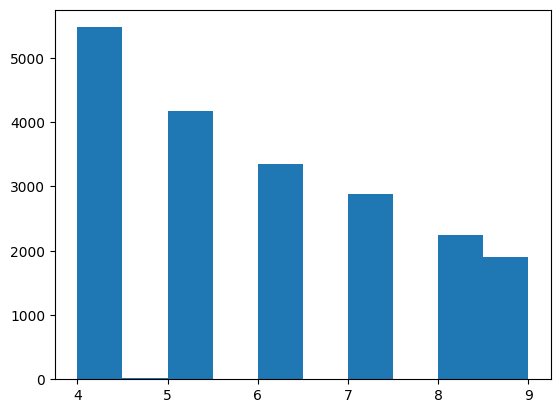

In [62]:
ratings = np.array(good_dataset["rating"])
plt.hist(ratings, 10)
plt.show()

In [63]:
def fix_rating(row):
    rating = row["rating"]
    row["rating"] = (
        rating
        if rating <= 5
        else min(5.0, 0.5 + (rating / 2))
    )

    return row
    
good_dataset = good_dataset.map(fix_rating)

Map:   0%|          | 0/20045 [00:00<?, ? examples/s]

In [64]:
good_dataset.push_to_hub("diwank/good_joke-dataset", private=True)
dataset.push_to_hub("diwank/taivop_joke-dataset", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/146 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.


In [65]:
set(good_dataset["category"])

{'',
 'Animal',
 'Animals',
 'At Work',
 'Bar',
 'Blond',
 'Blonde Jokes',
 'Business',
 'Children',
 'College',
 'Computers',
 'Crazy Jokes',
 'Deep Thoughts',
 'Family, Parents',
 'Gross',
 'Heaven and Hell',
 'Idiots',
 'Insults',
 'Knock-Knock',
 'Lawyer',
 'Light Bulbs',
 'Lightbulb',
 'Medical',
 'Men',
 'Men / Women',
 'Military',
 'Miscellaneous',
 'Music',
 'News / Politics',
 'One Liners',
 'Other / Misc',
 'Police Jokes',
 'Political',
 'Puns',
 'Redneck',
 'Religious',
 'Science',
 'Sex',
 'Sports',
 'Tech',
 'Women',
 'Yo Mama',
 'Yo Momma'}

In [78]:
good_dataset_pd = good_dataset.to_pandas()
good_dataset_pd[["category", "body"]].groupby("category").head(1)

,category,body
0,Animal,What do you call a cow with no legs?\nGround B...
1,Other / Misc,What's black and white and red all over?\nA ne...
2,Bar,There's this dyslexic guy... he walked into a ...
3,One Liners,There was a dyslexic insomniac agnostic.\nHe l...
4,Lawyer,What do you call 500 lawyers at the bottom of ...
5,Sports,What's the difference between a bad golfer and...
6,Religious,"A bishop, a priest, and a Rabbi walk into a ba..."
7,Lightbulb,How many psychologists does it take to change ...
12,Knock-Knock,Knock knock.\nWho's there?\ninterrupting cow\n...
13,Yo Momma,"Yo Mama's so ugly, I took her to the zoo, and ..."


In [130]:
categories_to_remove = [
    "Yo Momma",
    "Yo Mama",
    "Insults",
    "Redneck",
    "Blond",
    "Blonde Jokes",
    "Sex",
    "Police Jokes",
]

tasteful_jokes = good_dataset.filter(lambda row: row["category"] not in categories_to_remove)

Filter:   0%|          | 0/20045 [00:00<?, ? examples/s]

In [131]:
def by_type(row):
    body = row["title"] + ' ' + row["body"]
    body = body.lower().strip()
    body_space_split = body.split(' ')
    body_lines = body.split('\n')
    first_word = body_space_split[0]
    
    if "knock knock" in body:
        row["type"] = "knock_knock"

    elif 'blond' in body:
        row["type"] = "blonde"
        
    elif body.startswith('yo m'):
        row["type"] = "yo_mama"
        
    elif body.startswith('q: ') or first_word in [
        "what", "how", "who", "where", "when"
    ]:
        row["type"] = "qa_style"
        
    elif ': "' in body:
        row["type"] = "dialog_style"
        
    elif body.startswith('1. ') or '\n1. ' in body:
        row["type"] = "list_style"

    else:
        row["type"] = "other"

    return row

tasteful_jokes = tasteful_jokes.map(by_type)
tasteful_jokes = tasteful_jokes.filter(lambda row: row["type"] not in [
    "blonde", "yo_mama", "list_style", "dialog_style",
])

tasteful_jokes = tasteful_jokes.filter(lambda row: len(row["body"].split('\n')) < 5)

Map:   0%|          | 0/19837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19520 [00:00<?, ? examples/s]

In [132]:
tasteful_jokes = tasteful_jokes.filter(lambda row: (
    "~~~~" not in row["body"]
    and "----" not in row["body"]
))

Filter:   0%|          | 0/19429 [00:00<?, ? examples/s]

In [105]:
!poetry add better-profanity

Using version ^0.7.0 for better-profanity

Updating dependencies
Resolving dependencies... (3.5s)Resolving dependencies... (3.3s)

Package operations: 1 install, 0 updates, 0 removals

  • Installing better-profanity (0.7.0): Pending...
  • Installing better-profanity (0.7.0): Downloading... 0%
  • Installing better-profanity (0.7.0): Downloading... 88%
  • Installing better-profanity (0.7.0): Downloading... 100%
  • Installing better-profanity (0.7.0): Installing...
  • Installing better-profanity (0.7.0)

Writing lock file


In [135]:
def filter_profane(row):
    if row["source"] != "reddit_jokes":
        return True

    from better_profanity import profanity
    profanity.load_censor_words()

    body = row["title"] + ' ' + row["body"]
    body = body.lower()
    
    return (
        "black" not in body
        and "jew" not in body
        and not profanity.contains_profanity(body)
    )

# Drop profane reddit jokes coz they just bad
tasteful_jokes = tasteful_jokes.filter(filter_profane, num_proc=10)

Filter (num_proc=10):   0%|          | 0/15264 [00:00<?, ? examples/s]

In [136]:
tasteful_jokes

Dataset({
    features: ['source', 'body', 'title', 'category', 'rating', 'type'],
    num_rows: 15077
})

In [137]:
tasteful_jokes = tasteful_jokes.shuffle(seed=42)

for i, joke in enumerate(tasteful_jokes):
    if i > 100:
        break
        
    print(f"{joke['title']}\n\n{joke['body']}")
    print('-' * 20)
    print()

Why is a Christmas tree like a bridegroom?

After the big day, its balls are the first thing to come off.
--------------------

Why did the princess marry the barbarian?

Because she thought he was brutiful
--------------------

The Id, The Ego, and The Super Ego walk into a bar....

The Id, The Ego, and The Super Ego walk into a bar. No they didn't! Yes, they did! None of this even matters!
--------------------

Why are there so many French orphans in the fruit isle of the grocery store?

Because they are all looking for their pere
--------------------

I've been getting really sensitive teeth recently...

The dentist told me I wasn't taking care of them properly and they've been inconsolable ever since.
--------------------

How long is one minute?

It depends on what side of the bathroom door you're on.
--------------------

How do you start a rave in Africa?

Glue a piece of toast to the ceiling
--------------------



You know you're a good ol' boy computer operator if...
--------

### TODOS for joke dataset

- [ ] convert jokes that have questions or knock-knock into conversation style
- [ ] for example, "Q: Why did the chicken cross the road? A: Because ..." should turn into chatml { user("tell me a joke"), me("Ok, why did the chicken...?"), user("why?"), me("Because...") }
- [ ] similarly, "knock knock. who's there? interrupting cow. interrupting cow who? mooooo..." should turn into a series of turns.

- [ ] keep the source, and type columns
- [ ] then push to hub diwank/jokes-dataset